This is based on this code: https://github.com/codekansas/keras-language-modeling/blob/master/keras_models.py

In [6]:
#%load_ext autoreload
#%autoreload 2

## Note - To Get this working:

* Install CUDA and associated libraries, setup path
* Install bleeding edge theano (from src)
* Make sure the THEANO_FLAGS are set correctly via the environment var, or via the ~/.theanorc file
* Install and compile bleeding edge Keras (from src)
* `export KERAS_BACKEND=theano`
* `export KERAS_IMAGE_DIM_ORDERING='th'`
* `sh <project_root>/shell_scipts/setup_environment.sh` to install additional dependencies
* **DO NOT SET UNROLL=True** when creating RNN's - causes max recursion issue

## Trouble-Shooting

* You may need to clean the theano cache. To do so thoroughly, run this command from the shell:
 * `theano-cache purge`

In [49]:
import numpy as np
from collections import defaultdict
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, TimeDistributedDense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from Metrics import rpf1
from load_data import load_process_essays

#from gensim.models import Word2Vec
from window_based_tagger_config import get_config
from IdGenerator import IdGenerator as idGen
from results_procesor import ResultsProcessor, __MICRO_F1__
from Rpfa import micro_rpfa

import Settings
import logging

import datetime

In [8]:
#Helper Functions
def collapse_results(seq_lens, preds):
    assert len(seq_lens) == preds.shape[0], "Axis 1 size does not align"
    pred_ys_by_tag = defaultdict(list)
    for i in range(len(seq_lens)):
        row_ixs = preds[i,:]
        len_of_sequence = seq_lens[i] + 2
        pred_ys = [ix2tag[j] for j in row_ixs[-len_of_sequence:]]   
        # skip the start and end label
        pred_ys = pred_ys[1:-1]
        for pred_tag in pred_ys:
            pred_ys_by_tag[pred_tag].append(1)
            # for all other tags, a 0
            for tag in(vtags - set([EMPTY_TAG, pred_tag])):
                pred_ys_by_tag[tag].append(0)
        if EMPTY_TAG in pred_ys_by_tag:
            del pred_ys_by_tag[EMPTY_TAG]
    return pred_ys_by_tag

def split_dict(dct, train_split):
    td, vd = {}, {}
    for key, lst in dct.items():
        td[key] = lst[:train_split]
        vd[key] = lst[train_split:]
    return td, vd

## Load and Pre-Process Essays

In [9]:
from Settings import Settings

settings = Settings()
settings.data_directory + "CoralBleaching/Thesis_Dataset/"

Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/simon.hughes/GitHub/NlpResearch/
Public Data: /Users/simon.hughes/GitHub/NlpResearch/Data/PublicDatasets/


'/Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/Thesis_Dataset/'

In [10]:
from BrattEssay import load_bratt_essays
from load_data import load_process_essays
from collections import defaultdict
from IterableFP import flatten
from Settings import Settings
import pickle

settings = Settings()
root_folder = settings.data_directory + "CoralBleaching/Thesis_Dataset/"
training_folder = root_folder + "Training" + "/"
training_pickled = settings.data_directory + "CoralBleaching/Thesis_Dataset/training.pl"

Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/simon.hughes/GitHub/NlpResearch/
Public Data: /Users/simon.hughes/GitHub/NlpResearch/Data/PublicDatasets/


In [11]:
with open(training_pickled, "rb+") as f:
    tagged_essays = pickle.load(f)
len(tagged_essays)

902

In [12]:
import datetime, logging
print("Started at: " + str(datetime.datetime.now()))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()

TEST_SPLIT          = 0.2

Started at: 2017-03-14 21:14:28.071440


In [13]:
from numpy.random import shuffle
shuffle(tagged_essays)

## Prepare Tags

In [14]:
tag_freq = defaultdict(int)
unique_words = set()
for essay in tagged_essays:
    for sentence in essay.sentences:
        for word, tags in sentence:
            unique_words.add(word)
            for tag in tags:
                tag_freq[tag] += 1

EMPTY_TAG = "Empty"
regular_tags = list((t for t in tag_freq.keys() if t[0].isdigit()))
vtags = set(regular_tags)
vtags.add(EMPTY_TAG)

len(unique_words)

1641

In [15]:
sorted(vtags)

['1',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '50',
 '5b',
 '6',
 '7',
 'Empty']

# Transform Essays into Training Data (Word Ids)

In [16]:
from collections import defaultdict
generator = idGen(seed=1) # important as we zero pad sequences

ix2tag = {}
for ix, t in enumerate(vtags):
    ix2tag[ix] = t

def ids2tags(ids):
    return [generator.get_key(j) for j in ids]  

def lbls2tags(ixs):
    return [ix2tag[ix] for ix in ixs]

xs = []
ys = []

START = "<start>"
END   = "<end>"

# cut texts after this number of words (among top max_features most common words)
maxlen = 0
ys_bytag = defaultdict(list)
seq_lens = []
for essay in tagged_essays:
    for sentence in essay.sentences:
        row = []
        y_found = False
        y_seq = []
        for word, tags in [(START, set())] + sentence + [(END, set())]:
            id = generator.get_id(word) #starts at 0, but 0 used to pad sequences
            row.append(id)
            
            tags = vtags.intersection(tags)
            if word != START and word != END:
                for t in (vtags - set([EMPTY_TAG])):
                    if t in tags:
                        ys_bytag[t].append(1)
                    else:
                        ys_bytag[t].append(0)
            
            if len(tags) > 1:
                most_common = max(tags, key=lambda t: tag_freq[t])
                tags = set([most_common])
            if len(tags) == 0:
                tags.add(EMPTY_TAG)
            
            one_hot = []
            for t in vtags:
                if t in tags:
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            y_seq.append(one_hot)
    
        seq_lens.append(len(row)-2)
        ys.append(y_seq)
        xs.append(row)
        maxlen = max(len(row), maxlen)

max_features=len(generator.get_ids())+2 #Need plus one maybe due to masking of sequences

## Create Train - Test Split

In [17]:
maxlen = maxlen
num_training = int((1.0 - TEST_SPLIT) * len(xs))

X_train_orig, y_train_orig, X_test_orig, y_test_orig = \
    xs[:num_training], ys[:num_training], xs[num_training:], ys[num_training:]

seq_len_train, seq_len_test = seq_lens[:num_training], seq_lens[num_training:]

num_train_wds = sum(seq_len_train)
num_wds       = sum(seq_lens)
train_ys_bytag, test_ys_by_tag = split_dict(ys_bytag, num_train_wds)

In [18]:
X_train = sequence.pad_sequences(X_train_orig, maxlen=maxlen) #30 seems good
X_test  = sequence.pad_sequences(X_test_orig,  maxlen=maxlen)

y_train = sequence.pad_sequences(y_train_orig, maxlen=maxlen)
y_test  = sequence.pad_sequences(y_test_orig,  maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape: ',  X_test.shape)
print()
print('y_train shape:', y_train.shape)
print('y_test shape: ',  y_test.shape)

logging.info("Data Prepared")

2017-03-14 21:14:30,212 : INFO : Data Prepared


X_train shape: (6633, 93)
X_test shape:  (1659, 93)

y_train shape: (6633, 93, 14)
y_test shape:  (1659, 93, 14)


In [53]:
embedding_size = 128
hidden_size    = 128
out_size = len(vtags)
batch_size = 128

## Single Layer LSTM

In [20]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen, mask_zero=True))

# Fast - consume_less="CPU - BUT DON'T UNROLL
model.add(GRU(hidden_size, return_sequences=True, consume_less="cpu"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["categorical_crossentropy"], sample_weight_mode="temporal")

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


In [ ]:
%%time
from datetime import datetime

logging.info("Starting")

epochs = 20 #20

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics
logging.info("Ended")

In [24]:
micro_metrics

Recall: 0.4592, Precision: 0.7257, F1: 0.5625, Accuracy: 0.9861, Codes:  6810

In [15]:
code = "50"
assert len(test_pred_ys_by_tag[code]) == sum(seq_len_test) == len(test_ys_by_tag[code])
len(test_pred_ys_by_tag[code]), sum(seq_len_test), len(test_ys_by_tag[code])

(26466, 26466, 26466)

## Bi-Directional LSTM

In [26]:
from keras.layers import Bidirectional

embedding_size = 128
hidden_size    = 128
out_size = len(vtags)

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen, mask_zero=True))
#model.add(Bidirectional(LSTM(hidden_size, return_sequences=True, consume_less="cpu", unroll=True), merge_mode="sum"))
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


In [29]:
%%time
logging.info("Starting Training Bi-Directional LSTM")
batch_size = 128
epochs = 10 #20

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

2017-03-12 17:50:12,375 : INFO : Starting Training Bi-Directional LSTM


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 20s - loss: 0.4328 - fmeasure: 0.2896 - val_loss: 0.4089 - val_fmeasure: 0.2914

In [30]:
micro_metrics

Recall: 0.8134, Precision: 0.8441, F1: 0.8284, Accuracy: 0.9935, Codes:  6810

Bi-Directional LSTM, 128 hidden, 128 embedding, 20 epochs, batch size = 128

Recall: 0.8146, Precision: 0.8155, **F1: 0.8151**, Accuracy: 0.9930, Codes:  6549

## Timings

## Try with Pre-Trained Embedding

## Load Glove 100 Dim Embeddings

In [19]:
# see /Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/DeepLearning/WordVectors/pickle_glove_embedding.py
# for creating pre-filtered embeddings file
import pickle, os
embeddings_file = "/Users/simon.hughes/data/word_embeddings/glove.6B/cb_dict_glove.6B.100d.txt"

with open(embeddings_file, "rb+") as f:
    cb_emb_index = pickle.load(f)

In [20]:
from numpy.linalg import norm

v = list(cb_emb_index.values())
norms = []
for i in range(len(v)):
    norms.append(norm(v[i]))
mean_vec_len = np.mean(norms)
np.mean(norms), np.min(norms), np.max(norms)

(5.3327198, 2.332164, 8.0000887)

In [21]:
missed = set()
for wd in unique_words:
    if wd not in cb_emb_index:
        missed.add(wd)
print(len(missed), len(unique_words), 100.0 * round(len(missed)/  len(unique_words),4), "%")

41 1641 2.5 %


### Construct Embedding Matrix

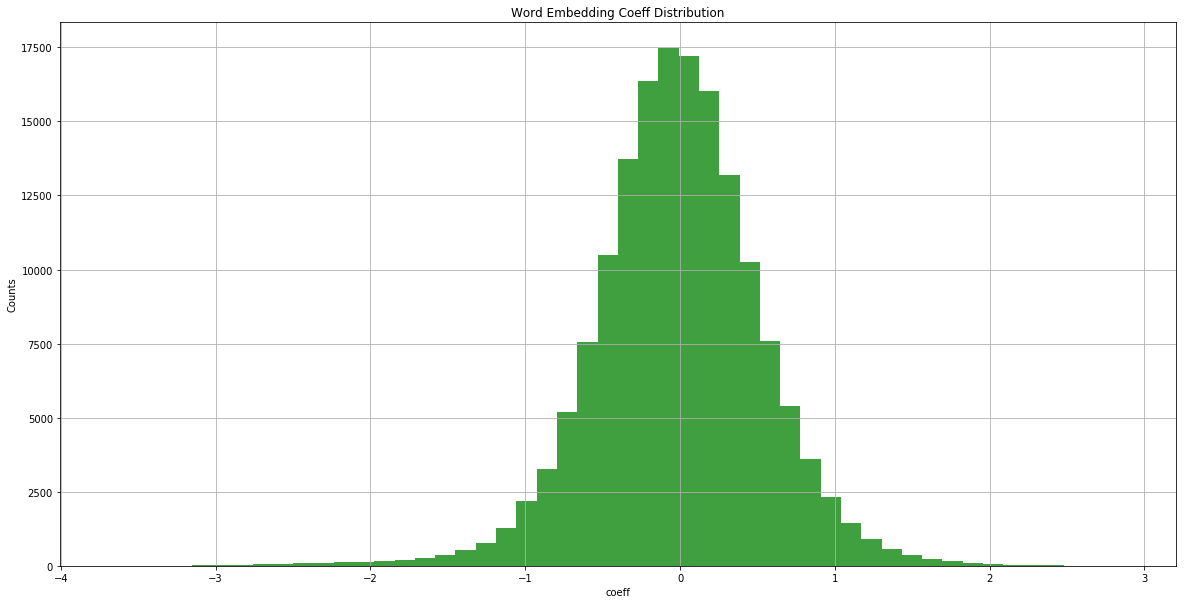

In [39]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

a = np.asarray(list(cb_emb_index.values()))
x = a.flatten()

# the histogram of the data
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(x, 50,  facecolor='green', alpha=0.75)
plt.xlabel('coeff')
plt.ylabel('Counts')
plt.title(r'Word Embedding Coeff Distribution')
plt.grid(True)

plt.show()

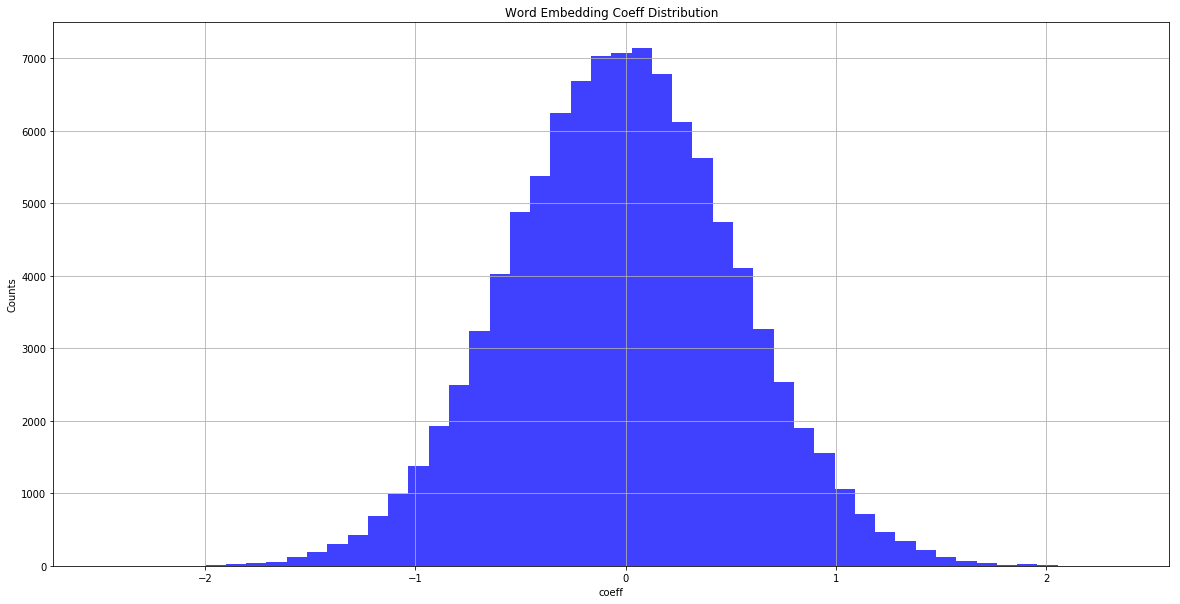

In [44]:
mean = x.mean()
sd = x.std()
rand = np.random.normal(mean, sd, size=(100000))

plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(rand, 50,  facecolor='blue', alpha=0.75)
plt.xlabel('coeff')
plt.ylabel('Counts')
plt.title(r'Random Embedding Seed Distribution')
plt.grid(True)

plt.show()

In [47]:
EMBEDDING_DIM = list(cb_emb_index.values())[0].shape[0]

def get_embedding_matrix(words, idgenerator, max_features, init='uniform', unit_length=False):
    embedding_dim = list(cb_emb_index.values())[0].shape[0]
    # initialize with a uniform distribution
    if init == 'uniform':
        embedding_matrix = np.random.uniform(low=-0.05, high=0.05,size=(max_features, embedding_dim))
    elif init =='zeros':
        embedding_matrix = np.zeros(shape=(max_features, embedding_dim), dtype=np.float32)
    elif init == 'normal':
        embedding_matrix = np.random.normal(mean, sd, size=(max_features, embedding_dim))
    else:
        raise Exception("Unknown init type")
    for word in words:
        i = idgenerator.get_id(word)
        embedding_vector = cb_emb_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    if unit_length:
        norms = np.linalg.norm(embedding_matrix, axis=1,keepdims=True)
        # remove 0 norms to prevent divide by zero
        norms[norms == 0.0] = 1.0
        embedding_matrix = embedding_matrix / norms
    return embedding_matrix

embedding_matrix = get_embedding_matrix(unique_words, generator, max_features)
embedding_matrix.shape

(1645, 100)

## Train Bi-Directional LSTM With Glove Embeddings

In [21]:
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
embedding_size = 128
hidden_size    = 128
out_size = len(vtags)

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


In [41]:
batch_size = 128
epochs = 10 #20

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

Train on 5306 samples, validate on 1327 samples
Epoch 1/5
5306/5306 [==============================] - 20s - loss: 1.0466 - fmeasure: 0.4087 - val_loss: 0.6743 - val_fmeasure: 0.3284

Recall: 0.7965, Precision: 0.8428, F1: 0.8190, Accuracy: 0.9932, Codes:  6810

**Pre-Trained Embeddings - Tuned:**

Bi-Directional LSTM, 128 hidden, 128 embedding, 20 epochs, batch size = 128

Recall: 0.8063, Precision: 0.8098, F1: **0.8080**, Accuracy: 0.9929, Codes:  6604

B-Directional **GRU**, 128 hidden, 128 embedding, **10 epochs**, batch size = 128

Recall: 0.8388, Precision: 0.8515, **F1: 0.8451**, Accuracy: 0.9940, Codes:  6810

## Try Different Embedding Initialization Schemes

### Zeros Init, Unit Length = True

In [34]:
epochs = 10
batch_size = 128

embedding_matrix = get_embedding_matrix(unique_words, generator, max_features, init='zeros', unit_length=True)
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 20s - loss: 1.2214 - fmeasure: 0.4045 - val_loss: 0.7743 - val_fmeasure: 0.3644

Recall: 0.7992, Precision: 0.8565, F1: 0.8269, Accuracy: 0.9938, Codes:  6588

### Zeros Init, Unit Length = False

In [35]:
epochs = 10
batch_size = 128

embedding_matrix = get_embedding_matrix(unique_words, generator, max_features, init='zeros', unit_length=False)
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 38s - loss: 1.0807 - fmeasure: 0.4505 - val_loss: 0.6513 - val_fmeasure: 0.3358

Recall: 0.8054, Precision: 0.8608, F1: 0.8322, Accuracy: 0.9940, Codes:  6588

### Uniform Init, Unit-Length = True

In [36]:
epochs = 10
batch_size = 128

embedding_matrix = get_embedding_matrix(unique_words, generator, max_features, init='uniform', unit_length=True)
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 25s - loss: 1.2145 - fmeasure: 0.3861 - val_loss: 0.7655 - val_fmeasure: 0.2788

Recall: 0.7549, Precision: 0.8898, F1: 0.8168, Accuracy: 0.9938, Codes:  6588

### UniformInit, Unit Length = False

In [37]:
embedding_matrix = get_embedding_matrix(unique_words, generator, max_features, init='uniform', unit_length=False)
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

epochs = 10
results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 24s - loss: 1.0398 - fmeasure: 0.4726 - val_loss: 0.6352 - val_fmeasure: 0.3265

Recall: 0.8277, Precision: 0.8398, F1: 0.8337, Accuracy: 0.9939, Codes:  6588

### Normal Distribution, Unit Length = False

In [55]:
embedding_matrix = get_embedding_matrix(unique_words, generator, max_features, init='normal', unit_length=False)
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True,
                            mask_zero=True) # If false, initialize unfound words with all 0's
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

epochs = 10
results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 20s - loss: 0.8835 - fmeasure: 0.3266 - val_loss: 0.5671 - val_fmeasure: 0.2808

Recall: 0.8025, Precision: 0.8614, F1: 0.8309, Accuracy: 0.9938, Codes:  6738

## Keep Embeddings Fixed

In [71]:
# Set trainable to false
embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False,
                            mask_zero=True) # If false, initialize unfound words with all 0's
embedding_size = 128
hidden_size    = 128
out_size = len(vtags)

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(hidden_size, return_sequences=True, consume_less="cpu", unroll=True), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

/Users/simon.hughes/anaconda3/envs/tensorflow_cpu/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


In [73]:
batch_size = 128
epochs = 10 #20

results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=1)
preds = model.predict_classes(X_test, batch_size=batch_size)   
test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
micro_metrics = micro_rpfa(class2metrics.values())
micro_metrics

Train on 5306 samples, validate on 1327 samples
Epoch 1/10
5306/5306 [==============================] - 31s - loss: 0.2680 - fmeasure: 0.3048 - val_loss: 0.2861 - val_fmeasure: 0.3040

Recall: 0.7735, Precision: 0.8121, F1: 0.7923, Accuracy: 0.9925, Codes:  6604

### TODO
* Switch to Theano backend - much faster for RNN's apparently (on GPU in particular)
* Look into masking
* Try Bi-Directional LSTM (see example below)
* Use early stopping criteria
* Embeddings:
 * Don't remove low frequency words
 * Normalize all vector lengths

## Fixed Embeddings

In [50]:
from keras.layers import Bidirectional

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False,
                            mask_zero=True) # If false, initialize unfound words with all 0's
embedding_size = 128
hidden_size    = 128
out_size = len(vtags)

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(hidden_size, return_sequences=True, consume_less="cpu"), merge_mode="sum"))

model.add(TimeDistributedDense(out_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['fmeasure'], sample_weight_mode="temporal")

/Users/simon.hughes/anaconda3/envs/keras_and_theano_bleeding_edge/lib/python3.5/site-packages/keras/layers/core.py:1206: UserWarning: `TimeDistributedDense` is deprecated, And will be removed on May 1st, 2017. Please use a `Dense` layer instead.
  warnings.warn('`TimeDistributedDense` is deprecated, '


In [52]:
epochs = 1
for i in range(20):
    epoch = i
    results = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=0.2, verbose=0)
    preds = model.predict_classes(X_test, batch_size=batch_size)   
    test_pred_ys_by_tag = collapse_results(seq_len_test, preds)
    class2metrics = ResultsProcessor.compute_metrics(test_ys_by_tag, test_pred_ys_by_tag)
    micro_metrics = micro_rpfa(class2metrics.values())
    print("Epoch={epoch}, Result={metrics}".format(epoch=epoch, metrics=str(micro_metrics)))

1659/1659 [==============================] - 2s     
Epoch=0, Result=Recall: 0.7555, Precision: 0.8855, F1: 0.8154, Accuracy: 0.9934, Codes:  6810
1659/1659 [==============================] - 2s     

### Appears to do a lot worse